In [249]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from scipy import stats
from scipy.stats import skew
from scipy.stats import chisquare
from scipy.stats import kruskal
import scikit_posthocs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

In [250]:
# load Data
df = pd.read_excel(r"C:\Users\rayde\Desktop\DSI_kickstarterscrape_dataset.xlsx", parse_dates=['funded date'])

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  


In [251]:
# Inspect columns: Should only choose features from the data set that we know prior to the outcome variable. 
# Possible X values - location, category, subcategory, goal, funded date (if decided at the onset o the project)
# Possible Y values - pledged, funded percentage, backers, status
df.columns

Index(['project id', 'name', 'url', 'category', 'subcategory', 'location',
       'status', 'goal', 'pledged', 'funded percentage', 'backers',
       'funded date', 'levels', 'reward levels', 'updates', 'comments',
       'duration'],
      dtype='object')

In [252]:
#View basic stats on data
df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


In [253]:
#Fill missing values
df.fillna(value=np.nan, inplace=True)

## Browse Duplicates

In [8]:
df[df['project id'].duplicated(keep=False)].sort_values(by='project id').head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
45651,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45652,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45653,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45654,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45655,2140513451,The Cookie Chew - Changing the Way We Eat a Co...,http://www.kickstarter.com/projects/1650956569...,Food,Food,"San Diego, CA",successful,4500.0,5540.0,1.231111,89,2010-08-24 04:43:00+00:00,5,"$10,$50,$75,$100,$500",14,17,43.27


## Drop Duplicates on Project Id / Drop Cancelled or Live Projects

In [9]:
new_df = df.drop_duplicates(subset=['project id'])
new_df = new_df.query('status == "successful" | status =="failed"')

In [10]:
new_df['status'].unique()

array(['successful', 'failed'], dtype=object)

## Fix inconsistent data entry / importation errors

In [11]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film &amp; Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art',
       'Board &amp; Card Games', 'Country &amp; Folk'], dtype=object)

In [12]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food', 'Film &amp; Video'], dtype=object)

In [13]:
new_df = new_df.replace(to_replace="Film &amp; Video", value="Film & Video")
new_df = new_df.replace(to_replace='Board &amp; Card Games', value="Board & Card Games")
new_df = new_df.replace(to_replace='Country &amp; Folk', value="Country & Folk")

In [14]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film & Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art'], dtype=object)

In [15]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food'], dtype=object)

In [16]:
new_df['name'] = new_df.name.str.replace("&quot;", '"')

In [17]:
new_df.name.iloc[4]

'Dinner Party - a short film about friendship... and revenge'

# Identify outliers in potential outcome variables

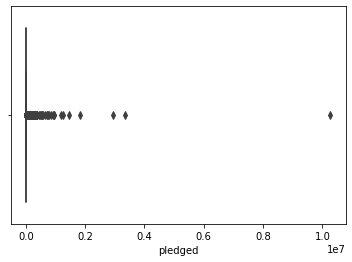

In [18]:
#It looks like we might want to drop at least one - three data points from pledged. 
# (There are some other outliers but that's not necessarily a bad thing. In this particular data set, 
# dropping too many outliers might homogenize the data set too much. In fact, it could be useful to analyze the outliers 
# on their own.)
sns.boxplot(x=df['pledged'])

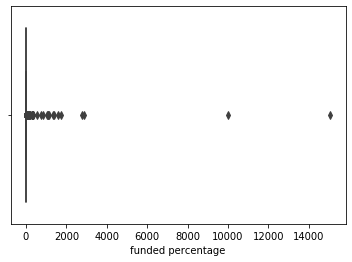

In [19]:
#It looks like we might want to drop at least two data points from pledged
sns.boxplot(x=df['funded percentage'])

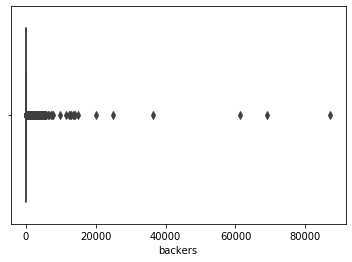

In [20]:
# We should probably drop at least the three data points above 60,000. 
sns.boxplot(x=df['backers'])

In [255]:
df['pledged'].sort_values(ascending=False).head()

10710    10266845.0
41151     3336372.0
42674     2933252.0
11231     1836447.0
35458     1464706.0
Name: pledged, dtype: float64

In [256]:
drop_columns = df['pledged'].sort_values(ascending=False).head(3).index
df.drop(drop_columns, axis=0, inplace=True)
df['pledged'].sort_values(ascending=False).head()

11231    1836447.0
35458    1464706.0
4086     1254120.0
17468    1192793.0
4114      942578.0
Name: pledged, dtype: float64

In [23]:
#Use the Inter Quartile Range to identify outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

project id           1.077617e+09
goal                 8.050000e+03
pledged              3.964750e+03
funded percentage    1.071608e+00
backers              5.400000e+01
levels               5.000000e+00
updates              6.000000e+00
comments             3.000000e+00
duration             1.839000e+01
dtype: float64


In [257]:
# In this particular data set there are a lot of data points that qualify as outliers or projects that have unusually 
# high performance. Thus, the IQR might not be the best strategy for this data set.
df[['pledged', 'funded percentage', 'backers']][(df[['pledged', 'funded percentage', 'backers']] < (Q1 - 1.5 * IQR)) |(df[['pledged', 'funded percentage', 'backers']] > (Q3 + 1.5 * IQR))].dropna()

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.
C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.


,pledged,funded percentage,backers
85,31047.0,3.104700,426.0
253,14366.0,9.577607,386.0
443,273725.0,3.649674,5661.0
452,11578.0,4.631200,383.0
503,32121.0,3.212100,261.0
...,...,...,...
45492,16423.0,5.474333,172.0
45661,12800.0,4.266770,332.0
45662,12800.0,4.266770,332.0
45783,17764.0,3.552800,235.0


In [263]:
# Identify outliers by Z-score
for each in ['funded percentage','backers', 'pledged']:
    df[f'z_{each}'] = np.abs(stats.zscore(df[each]))

In [262]:
drop_indices = df[df['z_funded percentage']> 3].sort_values('z_funded percentage', ascending=False).head(2).index
df.drop(drop_indices, axis=0, inplace=True)

In [264]:
drop_indices = df[df['z_backers']> 3].sort_values('z_backers', ascending=False).head(3).index
df.drop(drop_indices, axis=0, inplace=True)

In [265]:
drop_indices = df[df['z_pledged']> 3].sort_values('z_pledged', ascending=False).head(3).index
df.drop(drop_indices, axis=0, inplace=True)

## Create new features out of funded date and location

In [266]:
new_df['duration_td'] = new_df.duration.apply(lambda x: datetime.timedelta(days=x))
new_df[['duration','duration_td']].dtypes

duration               float64
duration_td    timedelta64[ns]
dtype: object

In [267]:
new_df['Posting_Date'] = new_df['funded date'] - new_df['duration_td']
new_df[['Posting_Date','duration','duration_td', 'funded date']].head()

,Posting_Date,duration,duration_td,funded date
0,2011-07-20 19:28:17+00:00,30.00,30 days 00:00:00,2011-08-19 19:28:17+00:00
1,2010-06-15 23:39:48+00:00,47.18,47 days 04:19:12,2010-08-02 03:59:00+00:00
3,2012-03-06 20:57:12+00:00,32.22,32 days 05:16:48,2012-04-08 02:14:00+00:00
4,2011-05-02 15:25:39+00:00,30.00,30 days 00:00:00,2011-06-01 15:25:39+00:00
5,2011-06-01 03:13:48+00:00,21.43,21 days 10:19:12,2011-06-22 13:33:00+00:00


In [268]:
new_df['year_funded'] = new_df['funded date'].dt.year
new_df['month_funded'] = new_df['funded date'].dt.month
new_df['day_funded'] = new_df['funded date'].dt.day
new_df['time_funded'] = new_df['funded date'].dt.time
new_df['dayOfWeek_funded'] = new_df['funded date'].dt.dayofweek
new_df[['year_funded','month_funded', 'day_funded', 'time_funded', 'dayOfWeek_funded']]

,year_funded,month_funded,day_funded,time_funded,dayOfWeek_funded
0,2011,8,19,19:28:17,4
1,2010,8,2,03:59:00,0
3,2012,4,8,02:14:00,6
4,2011,6,1,15:25:39,2
5,2011,6,22,13:33:00,2
...,...,...,...,...,...
45952,2012,3,30,13:57:00,4
45953,2012,4,22,02:12:10,6
45954,2012,1,16,05:00:00,0
45955,2012,5,19,19:44:47,5


In [269]:
new_df['year_posted'] = new_df['Posting_Date'].dt.year
new_df['month_posted'] = new_df['Posting_Date'].dt.month
new_df['day_posted'] = new_df['Posting_Date'].dt.day
new_df['time_posted'] = new_df['Posting_Date'].dt.time
new_df['dayOfWeek_posted'] = new_df['Posting_Date'].dt.dayofweek
new_df[['year_posted','month_posted', 'day_posted', 'time_posted', 'dayOfWeek_posted']]

,year_posted,month_posted,day_posted,time_posted,dayOfWeek_posted
0,2011,7,20,19:28:17,2
1,2010,6,15,23:39:48,1
3,2012,3,6,20:57:12,1
4,2011,5,2,15:25:39,0
5,2011,6,1,03:13:48,2
...,...,...,...,...,...
45952,2012,2,21,18:01:48,1
45953,2012,2,22,03:09:46,2
45954,2011,12,19,21:19:12,0
45955,2012,4,19,19:44:47,3


In [270]:
new_df['city'], new_df['state'] = new_df['location'].str.split(', ', 1).str
new_df[['city', 'state', 'location']]

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,city,state,location
0,Columbia,MO,"Columbia, MO"
1,Maplewood,NJ,"Maplewood, NJ"
3,Los Angeles,CA,"Los Angeles, CA"
4,Novi,MI,"Novi, MI"
5,Portland,OR,"Portland, OR"
...,...,...,...
45952,Austin,TX,"Austin, TX"
45953,Los Angeles,CA,"Los Angeles, CA"
45954,Los Angeles,CA,"Los Angeles, CA"
45955,Vero Beach,FL,"Vero Beach, FL"


In [271]:
new_df['city'].unique()

array(['Columbia', 'Maplewood', 'Los Angeles', ..., 'Peaks',
       'Lumberville', 'Lake Oswego'], dtype=object)

In [272]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'Taiwan', 'IN', 'Norway', 'MN', 'NC', 'MA',
       'PA', 'CT', 'Chile', 'MD', 'HI', 'VA', 'WA', 'AZ', 'OH', 'NV',
       'Haiti', 'GA', 'AL', 'UT', 'Canada', 'LA', 'SC', 'Ecuador', 'WI',
       'Jamaica', 'Argentina', 'Hong Kong', 'Germany', 'NM', 'NE',
       'Guatemala', 'IA', 'WY', 'Australia', 'RI', 'Sweden', 'OK', 'DE',
       'South Africa', 'AK', 'WV', 'Nepal', 'MT', 'KY', 'VT', 'Kenya',
       'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'KS', 'Hungary',
       'Indonesia', 'China', 'SD', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'NH', 'New Zealand', 'France',
       'United Kingdom', 'Austria', 'Turkey', 'AR', 'Mt', 'Congo',
       'Colombia', 'India', 'Mongolia', 'MS', 'Israel', 'Dominica',
       'Finland', 'Czech Republic', 'Japan', 'Virgin Islands, U.S.',
       'Lebanon', 'Armenia', 'Portugal', 'Qatar', 'Morocco', 'Martinique',
       'Pue

In [273]:
new_df = new_df.replace(to_replace='Virginia', value="VA")

In [274]:
x, y = new_df[new_df.state == 'Middleburg, MD']['state'].str.split(', ', 1).str
row_val = list(new_df[new_df.state == 'Middleburg, MD'].index)[0]

new_df.loc[[row_val],['city']] = x
new_df.loc[[row_val], ['state']]= y

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [275]:
new_df['country'] = new_df['state'].replace(to_replace=r'^..{1}$', value="USA", regex=True)
new_df[new_df.country != 'USA'].head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,category_dummy,subcategory_dummy,status_dummy,year_posted_dummy,year_funded_dummy,month_posted_dummy,month_funded_dummy,country_dummy,year_month_posted,year_month_funded
11,727286,Offline Wikipedia iPhone app,http://www.kickstarter.com/projects/dphiffer/o...,Technology,Open Software,NaN,successful,99.0,145.0,1.464646,...,11,31,1,0,0,3,6,54,2,4
14,893085,Esperanza Farm: A Novel,http://www.kickstarter.com/projects/JesusMaria...,Publishing,Fiction,NaN,failed,6500.0,765.0,0.117692,...,10,16,0,1,1,4,6,54,15,16
29,1512678,Eyes and Ears on English - comedy/English educ...,http://www.kickstarter.com/projects/1787808582...,Film & Video,Film & Video,"Taipei, Taiwan",failed,12000.0,1502.0,0.125167,...,5,17,0,2,2,3,4,37,26,26
42,2117470,""" Hugo's There "" - Real News. Unbelievably.",http://www.kickstarter.com/projects/mastermind...,Film & Video,Webseries,"Oslo, Norway",failed,8400.0,25.0,0.002976,...,5,47,0,2,2,6,8,37,29,30
49,2442649,Dream with Me--A documentary about one year in...,http://www.kickstarter.com/projects/1800556280...,Film & Video,Documentary,NaN,successful,5000.0,5615.0,1.123000,...,5,13,1,0,0,8,9,54,7,7


In [276]:
series_1 = new_df[new_df.country != 'USA']['state'].apply(lambda x: np.nan)
indices= list(new_df[new_df.country != 'USA'].index)
new_df.loc[indices, ['state']] = series_1

In [277]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'IN', 'MN', 'NC', 'MA', 'PA', 'CT', 'MD',
       'HI', 'VA', 'WA', 'AZ', 'OH', 'NV', 'GA', 'AL', 'UT', 'LA', 'SC',
       'WI', 'NM', 'NE', 'IA', 'WY', 'RI', 'OK', 'DE', 'AK', 'WV', 'MT',
       'KY', 'VT', 'KS', 'SD', 'NH', 'AR', 'Mt', 'MS', 'ND'], dtype=object)

In [278]:
new_df['country'].unique()

array(['USA', nan, 'Taiwan', 'Norway', 'Chile', 'Haiti', 'Canada',
       'Ecuador', 'Jamaica', 'Argentina', 'Hong Kong', 'Germany',
       'Guatemala', 'Australia', 'Sweden', 'South Africa', 'Nepal',
       'Kenya', 'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'Hungary',
       'Indonesia', 'China', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'New Zealand', 'France', 'United Kingdom',
       'Austria', 'Turkey', 'Congo', 'Colombia', 'India', 'Mongolia',
       'Israel', 'Dominica', 'Finland', 'Czech Republic', 'Japan',
       'Virgin Islands, U.S.', 'Lebanon', 'Armenia', 'Portugal', 'Qatar',
       'Morocco', 'Martinique', 'Puerto Rico', 'Afghanistan', 'Denmark',
       'Tanzania', 'Kazakhstan', 'Zambia', 'Switzerland', 'Egypt',
       'Svalbard and Jan Mayen', 'Liberia', 'Ghana', 'Nicaragua',
       'Russia', 'Ukraine', 'Bulgaria', 'South Korea', 'Brazil', 'Rwanda',
       'Spain', 'Costa Rica', 'Philippines', 'Pakistan', 'El Salvador',
       'Panama', 

In [279]:
new_df['country'] = new_df['country'].astype('str')
new_df[new_df.country == 'nan'][['location', 'country']].head()

,location,country
11,NaN,nan
14,NaN,nan
49,NaN,nan
98,NaN,nan
100,NaN,nan


In [280]:
series1 = new_df[new_df['country']=='nan']['country'].apply(lambda x: np.nan)
indices = series1.index
new_df.loc[indices, ['country']] = series_1

In [281]:
new_df.loc[indices, ['country']].head()

,country
11,NaN
14,NaN
49,NaN
98,NaN
100,NaN


## Create Dummy Variables Using LabelEncoder()

In [282]:
obj_cols = ['category', 'subcategory', 'status', 'year_posted', 'year_funded', 'month_posted', 'month_funded']
label_encoder = LabelEncoder()
for col in obj_cols:
    try:
        new_df[col+"_dummy"] = label_encoder.fit_transform(new_df[col])
    except:
        print('problem with' + col)

In [283]:
countries = new_df.country
country_counts = countries.value_counts()

mask = countries.isin(country_counts[country_counts < 10].index)

# Label all other categories as Other
countries[mask] = 'Other'

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [284]:
new_df['country'] = new_df['country'].astype('str')
new_df.country
new_df['country_dummy'] = label_encoder.fit_transform(new_df['country'])

In [285]:
new_df[['status','status_dummy']]

,status,status_dummy
0,successful,1
1,failed,0
3,successful,1
4,failed,0
5,successful,1
...,...,...
45952,successful,1
45953,failed,0
45954,successful,1
45955,failed,0


In [286]:
new_df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration,duration_td,...,category_dummy,subcategory_dummy,status_dummy,year_posted_dummy,year_funded_dummy,month_posted_dummy,month_funded_dummy,country_dummy,year_month_posted,year_month_funded
count,4.184100e+04,4.184100e+04,4.184100e+04,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841,...,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000
mean,1.078276e+09,1.041084e+04,5.128665e+03,1.980354,71.098731,7.950646,4.335580,8.327287,40.232153,40 days 05:34:17.990965799,...,6.258072,26.105423,0.547358,2.025501,2.123205,4.918358,5.079993,49.872493,26.054994,26.390956
std,6.197736e+08,1.480363e+05,5.916179e+04,92.728555,713.994952,4.192497,6.628569,175.451017,17.786219,17 days 18:52:09.326775168,...,3.160544,13.910777,0.497758,0.754904,0.744352,3.488458,3.331319,6.445682,8.005827,7.909144
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.426141e+08,1.650000e+03,2.200000e+02,0.051667,5.000000,5.000000,0.000000,0.000000,30.000000,30 days 00:00:00,...,5.000000,14.000000,0.000000,2.000000,2.000000,2.000000,2.000000,51.000000,21.000000,22.000000
50%,1.077801e+09,4.000000e+03,1.450000e+03,1.005167,25.000000,7.000000,2.000000,1.000000,32.080000,32 days 01:55:12,...,6.000000,27.000000,1.000000,2.000000,2.000000,4.000000,4.000000,51.000000,27.000000,28.000000
75%,1.616992e+09,8.800000e+03,4.400000e+03,1.130000,61.000000,10.000000,6.000000,3.000000,49.080000,49 days 01:55:12,...,8.000000,41.000000,1.000000,3.000000,3.000000,8.000000,8.000000,51.000000,33.000000,33.000000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.000000,19311.000000,91.960000,91 days 23:02:24,...,12.000000,48.000000,1.000000,3.000000,3.000000,11.000000,11.000000,54.000000,37.000000,37.000000


In [287]:
#create interaction between month and year
new_df['year_month_posted'] = new_df['year_posted'].astype('str') + "_" + new_df['month_posted_dummy'].astype('str')
new_df['year_month_posted'] = label_encoder.fit_transform(new_df['year_month_posted'])
new_df['year_month_posted'].describe()

count    41841.000000
mean        26.054994
std          8.005827
min          0.000000
25%         21.000000
50%         27.000000
75%         33.000000
max         37.000000
Name: year_month_posted, dtype: float64

In [288]:
#create interaction between month and year
new_df['year_month_funded'] = new_df['year_funded'].astype('str') + "_" + new_df['month_funded_dummy'].astype('str')
new_df['year_month_funded'] = label_encoder.fit_transform(new_df['year_month_funded'])
new_df['year_month_funded'].describe()

count    41841.000000
mean        26.390956
std          7.909144
min          0.000000
25%         22.000000
50%         28.000000
75%         33.000000
max         37.000000
Name: year_month_funded, dtype: float64

# Exploratory Analysis

## Check Skewness and test for normal distribution
##### mean greater than median, positively skewed
##### mean less than median, negatively skewed
##### mean = median, symmetrical distribution

#### The normal test tests if the distribution of the variable differs from the normal distribution - This is important because the results indicate whether parametric or nonparametric statistical tests should be used. 

In [289]:
x_vars = ['goal', 'updates', 'comments', 'duration', 'year_posted_dummy', 'year_funded_dummy', 
          'month_posted_dummy', 'month_funded_dummy','day_posted', 'day_funded', 'dayOfWeek_posted', 'dayOfWeek_funded', 'category_dummy', 
          'subcategory_dummy', 'year_month_posted', 'year_month_funded']
y_vars = ['pledged', 'funded percentage', 'backers', 'status_dummy']

In [290]:
new_df.skew(axis = 0, skipna = True)

project id             -0.008691
goal                  132.451022
pledged               134.091965
funded percentage     134.417943
backers                85.971300
levels                  2.607894
updates                 3.907637
comments               71.633083
duration                1.066485
year_funded            -0.445769
month_funded            0.288752
day_funded              0.057872
dayOfWeek_funded       -0.108342
year_posted            -0.385792
month_posted            0.287381
day_posted              0.052742
dayOfWeek_posted        0.233772
category_dummy         -0.281979
subcategory_dummy      -0.074178
status_dummy           -0.190294
year_posted_dummy      -0.385792
year_funded_dummy      -0.445769
month_posted_dummy      0.287381
month_funded_dummy      0.288752
country_dummy          -5.658267
year_month_posted      -0.773060
year_month_funded      -0.832694
dtype: float64

In [291]:
#Reject the null that they are normally distributed
for each in x_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))
for each in y_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))

goal: NormaltestResult(statistic=181221.97474867204, pvalue=0.0)
updates: NormaltestResult(statistic=35981.269196937435, pvalue=0.0)
comments: NormaltestResult(statistic=148916.91323430266, pvalue=0.0)
duration: NormaltestResult(statistic=6185.700723610547, pvalue=0.0)
year_posted_dummy: NormaltestResult(statistic=1166.7593889551026, pvalue=4.3794324700114634e-254)
year_funded_dummy: NormaltestResult(statistic=1611.3934272908994, pvalue=0.0)
month_posted_dummy: NormaltestResult(statistic=48094.14473316772, pvalue=0.0)
month_funded_dummy: NormaltestResult(statistic=14727.479581701287, pvalue=0.0)
day_posted: NormaltestResult(statistic=30782.809488430856, pvalue=0.0)
day_funded: NormaltestResult(statistic=36756.83174117571, pvalue=0.0)
dayOfWeek_posted: NormaltestResult(statistic=9129.33885408962, pvalue=0.0)
dayOfWeek_funded: NormaltestResult(statistic=63622.4356716953, pvalue=0.0)
category_dummy: NormaltestResult(statistic=1072.5833590653822, pvalue=1.2344766744891414e-233)
subcategory

## Look at Relationship between outcome variables and duration
#### There seems to be a consistent jump in pledged, percent funded, and backers at around 30 days duration

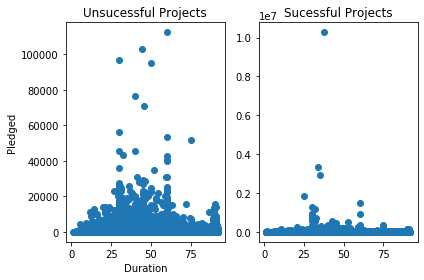

In [311]:
y1 = new_df[new_df['status_dummy']==0]['pledged']
y2 = new_df[new_df['status_dummy']==1]['pledged']

x1 = new_df[new_df['status_dummy']==0]['duration']
x2 = new_df[new_df['status_dummy']==1]['duration']

plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.xlabel('Duration')
plt.ylabel('Pledged')
plt.title('Unsucessful Projects')

plt.subplot(1, 2, 2)
plt.scatter(x2, y2)
plt.title('Sucessful Projects')

plt.tight_layout()
plt.show()

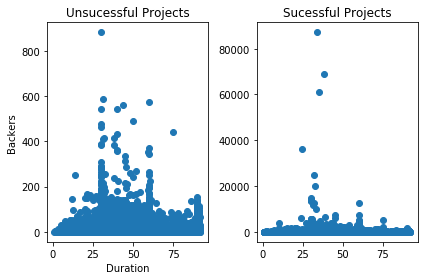

In [308]:
y1 = new_df[new_df['status_dummy']==0]['backers']
y2 = new_df[new_df['status_dummy']==1]['backers']

x1 = new_df[new_df['status_dummy']==0]['duration']
x2 = new_df[new_df['status_dummy']==1]['duration']

plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.xlabel('Duration')
plt.ylabel('Backers')
plt.title('Unsucessful Projects')

plt.subplot(1, 2, 2)
plt.scatter(x2, y2)
plt.title('Sucessful Projects')

plt.tight_layout()
plt.show()

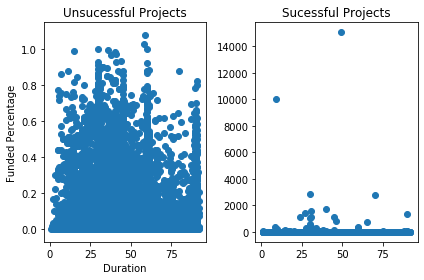

In [312]:
y1 = new_df[new_df['status_dummy']==0]['funded percentage']
y2 = new_df[new_df['status_dummy']==1]['funded percentage']

x1 = new_df[new_df['status_dummy']==0]['duration']
x2 = new_df[new_df['status_dummy']==1]['duration']

plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.xlabel('Duration')
plt.ylabel('Funded Percentage')
plt.title('Unsucessful Projects')

plt.subplot(1, 2, 2)
plt.scatter(x2, y2)
plt.title('Sucessful Projects')

plt.tight_layout()
plt.show()

In [63]:
y = new_df[['duration',"status_dummy"]].groupby('status_dummy').mean()

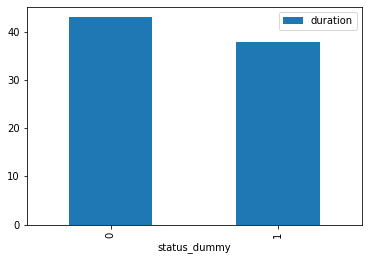

In [64]:
y.plot.bar()

## Check to see if project listing date is independent to month, day, year, and day of week
#### The Chi-Square test is a statistical hypothesis test to check independence of categorical variables. In this context, we use this test to see if projects are more or less likely to be posted in certain months, on certain days, or in particular years.

In [65]:
month_posted = new_df['project id'].groupby(new_df['month_posted_dummy']).count()
stats.chisquare(month_posted)

Power_divergenceResult(statistic=2776.5209005520896, pvalue=0.0)

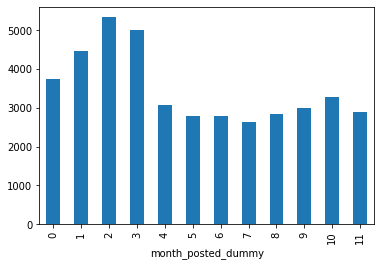

In [66]:
month_posted.plot.bar()

In [67]:
month_funded = new_df['project id'].groupby(new_df['month_funded_dummy']).count()
stats.chisquare(month_funded)

Power_divergenceResult(statistic=3348.6238617623862, pvalue=0.0)

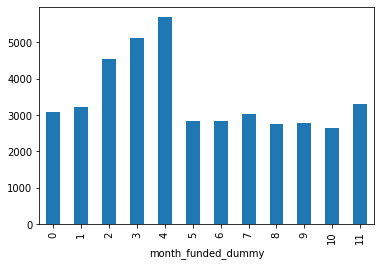

In [68]:
month_funded.plot.bar()

In [69]:
day_posted = new_df['project id'].groupby(new_df['day_posted']).count()
stats.chisquare(day_posted)

Power_divergenceResult(statistic=664.074950407495, pvalue=1.4887333283985904e-120)

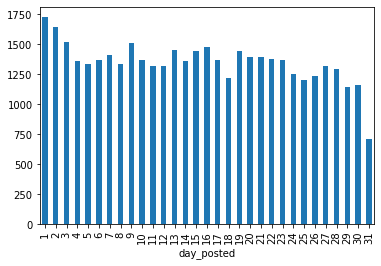

In [70]:
day_posted.plot.bar()

In [71]:
day_funded = new_df['project id'].groupby(new_df['day_funded']).count()
stats.chisquare(day_funded)

Power_divergenceResult(statistic=2642.9375492937547, pvalue=0.0)

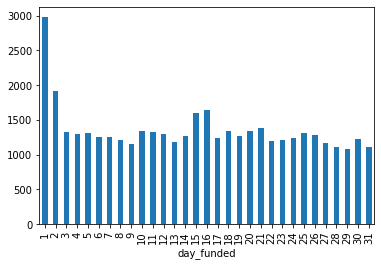

In [72]:
day_funded.plot.bar()

In [73]:
year_posted = new_df['project id'].groupby(new_df['year_posted']).count()
stats.chisquare(year_posted)

Power_divergenceResult(statistic=19780.878540187856, pvalue=0.0)

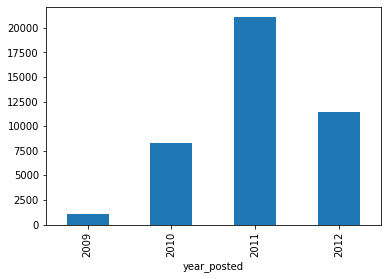

In [74]:
year_posted.plot.bar()

In [75]:
year_funded = new_df['project id'].groupby(new_df['year_funded']).count()
stats.chisquare(year_funded)

Power_divergenceResult(statistic=20089.310747831074, pvalue=0.0)

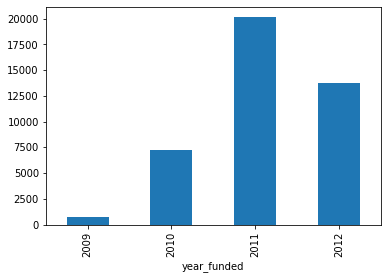

In [76]:
year_funded.plot.bar()

In [77]:
weekDay_posted = new_df['project id'].groupby(new_df['dayOfWeek_posted']).count()
stats.chisquare(weekDay_posted)

Power_divergenceResult(statistic=2879.8277765827775, pvalue=0.0)

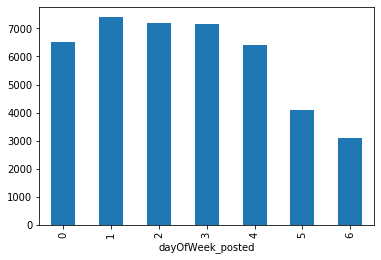

In [78]:
weekDay_posted.plot.bar()

In [79]:
weekDay_funded = new_df['project id'].groupby(new_df['dayOfWeek_funded']).count()
stats.chisquare(weekDay_funded)

Power_divergenceResult(statistic=295.2817571281757, pvalue=8.387785658465541e-61)

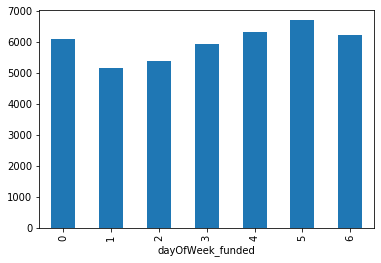

In [80]:
weekDay_funded.plot.bar()

## Check for joint significance of month, day of week, and year 
#### The F-test tests multiple hypothesis. The null hypothesis is that all slopes/coefficients are zero. Unfortunately the data isn't normally distributed so a parametric test probably isn't appropriate.
##### Month dummies: Jointly significant; Reject Null
##### Year dummies: Jointly significant; Reject Null
##### Day of week dummies: Not Jointly Significant; Do not reject the null

In [81]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'month_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 2], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 3],
              new_df['status_dummy'][new_df[f'month_{each}'] == 4],
              new_df['status_dummy'][new_df[f'month_{each}'] == 5],
              new_df['status_dummy'][new_df[f'month_{each}'] == 6],
              new_df['status_dummy'][new_df[f'month_{each}'] == 7],
              new_df['status_dummy'][new_df[f'month_{each}'] == 8],
              new_df['status_dummy'][new_df[f'month_{each}'] == 9],
              new_df['status_dummy'][new_df[f'month_{each}'] == 10],
              new_df['status_dummy'][new_df[f'month_{each}'] == 11],
              new_df['status_dummy'][new_df[f'month_{each}'] == 12]))

Posted: F_onewayResult(statistic=2.7794177318667224, pvalue=0.001290621161661944)
Funded: F_onewayResult(statistic=4.211975575580128, pvalue=2.8486971326095864e-06)


In [82]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'year_{each}'] == 2009], 
               new_df['status_dummy'][new_df[f'year_{each}'] == 2010], 
               new_df['status_dummy'][new_df[f'year_{each}'] == 2011],
              new_df['status_dummy'][new_df[f'year_{each}'] == 2012]))

Posted: F_onewayResult(statistic=6.31445909442635, pvalue=0.0002814123156969091)
Funded: F_onewayResult(statistic=15.196937914090293, pvalue=7.012146438986875e-10)


In [83]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 0], 
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 2],
             new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 3], 
              new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 4],  
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 5],
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 6]))

Posted: F_onewayResult(statistic=7.054726074512105, pvalue=1.5977152142137403e-07)
Funded: F_onewayResult(statistic=1.4494149509388263, pvalue=0.1914102900357102)


## Kruskal-Wallis Test
#### Kruskal-Wallis test is a nonparametric version of the ANOVA test ; Interprets the MEDIAN difference

In [84]:
# compare samples
for each in ['posted', 'funded']:
 
    stat, p = kruskal(new_df['status_dummy'][new_df[f'month_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 2], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 3],
              new_df['status_dummy'][new_df[f'month_{each}'] == 4],
              new_df['status_dummy'][new_df[f'month_{each}'] == 5],
              new_df['status_dummy'][new_df[f'month_{each}'] == 6],
              new_df['status_dummy'][new_df[f'month_{each}'] == 7],
              new_df['status_dummy'][new_df[f'month_{each}'] == 8],
              new_df['status_dummy'][new_df[f'month_{each}'] == 9],
              new_df['status_dummy'][new_df[f'month_{each}'] == 10],
              new_df['status_dummy'][new_df[f'month_{each}'] == 11],
              new_df['status_dummy'][new_df[f'month_{each}'] == 12])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=30.559, p=0.001
Different distributions (reject H0)
Funded Statistics=46.293, p=0.000
Different distributions (reject H0)


In [85]:
# compare samples
for each in ['posted', 'funded']:
    stat, p = kruskal(new_df['status_dummy'][new_df[f'year_{each}'] == 2009], 
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2010],
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2011],
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2012])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=18.936, p=0.000
Different distributions (reject H0)
Funded Statistics=45.544, p=0.000
Different distributions (reject H0)


In [86]:
# compare samples
for each in ['posted', 'funded']:
    stat, p = kruskal(new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 0], 
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 1], 
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 2],
                 new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 3], 
                  new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 4],  
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 5],
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 6])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=42.292, p=0.000
Different distributions (reject H0)
Funded Statistics=8.696, p=0.191
Same distributions (fail to reject H0)


## Dunn's Test
#### Dunn's test pinpoints which means are significantly different than the others
#### This section conducts the Dunn's test between 'status_dummy' and 'month', 'year', 'day of week' and 'year_month.'


In [87]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='month_posted', p_adjust='bonferroni')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,0.027101,0.680131,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.158743,1.000000,1.000000
2,0.027101,1.000000,1.000000,1.0,0.063191,0.202866,1.0,1.0,0.544404,1.000000,0.667578,0.126044
3,0.680131,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
5,1.000000,0.063191,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.276478,1.000000,1.000000
6,1.000000,0.202866,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.672972,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
9,1.000000,0.544404,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
10,0.158743,1.000000,1.000000,1.0,0.276478,0.672972,1.0,1.0,1.000000,1.000000,1.000000,0.467064


In [88]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='month_funded', p_adjust='bonferroni')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,1.0,0.269449,0.083151,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.228951,1.000000
2,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
3,0.269449,1.0,1.000000,1.000000,0.023152,0.838899,0.085376,1.0,1.0,1.0,1.000000,0.005146
4,0.083151,1.0,1.000000,1.000000,0.003695,0.311561,0.023809,1.0,1.0,1.0,1.000000,0.000948
5,1.000000,1.0,0.023152,0.003695,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.034919,1.000000
6,1.000000,1.0,0.838899,0.311561,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.627222,1.000000
7,1.000000,1.0,0.085376,0.023809,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.080245,1.000000
8,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
9,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
10,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000


In [89]:
# 2010 and 2011 are significantly different 
# 2011 and 2012 are significantly different
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_posted', p_adjust='bonferroni')

,2009,2010,2011,2012
2009,1.0,1.000000,1.000000,1.00000
2010,1.0,1.000000,0.007564,1.00000
2011,1.0,0.007564,1.000000,0.00093
2012,1.0,1.000000,0.000930,1.00000


In [90]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_funded', p_adjust='bonferroni')

,2009,2010,2011,2012
2009,1.000000,1.000000,4.511020e-01,1.000000e+00
2010,1.000000,1.000000,1.095175e-03,9.969441e-01
2011,0.451102,0.001095,1.000000e+00,6.314071e-10
2012,1.000000,0.996944,6.314071e-10,1.000000e+00


In [91]:
#Sunday, Monday, and Tuesday are the best days to post a new campaign
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='dayOfWeek_posted', p_adjust='bonferroni')

,0,1,2,3,4,5,6
0,1.000000,1.000000,1.000000,0.628016,0.067526,0.000672,0.002054
1,1.000000,1.000000,1.000000,0.340379,0.029403,0.000233,0.000875
2,1.000000,1.000000,1.000000,1.000000,0.149575,0.001643,0.004611
3,0.628016,0.340379,1.000000,1.000000,1.000000,0.410119,0.548987
4,0.067526,0.029403,0.149575,1.000000,1.000000,1.000000,1.000000
5,0.000672,0.000233,0.001643,0.410119,1.000000,1.000000,1.000000
6,0.002054,0.000875,0.004611,0.548987,1.000000,1.000000,1.000000


In [92]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='dayOfWeek_funded', p_adjust='bonferroni')

,0,1,2,3,4,5,6
0,1.000000,0.405313,1.0,1.000000,0.864544,1.0,1.0
1,0.405313,1.000000,1.0,0.872227,1.000000,1.0,1.0
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
3,1.000000,0.872227,1.0,1.000000,1.000000,1.0,1.0
4,0.864544,1.000000,1.0,1.000000,1.000000,1.0,1.0
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0


In [93]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_month_posted', p_adjust='bonferroni')

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,0.310324,0.154507,0.340654,1.000000,0.074703,1.000000,0.209604,1.00000,1.000000,1.000000
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [94]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_month_funded', p_adjust='bonferroni')

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
1,1.0,1.000000,1.0,1.0,0.172898,1.0,1.0,1.0,1.0,0.757344,...,0.538297,0.105584,0.371606,0.373413,1.000000,1.000000,0.344977,0.725151,1.000000e+00,1.000000
2,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
3,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
4,1.0,0.172898,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.990802
5,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
6,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
7,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
8,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
9,1.0,0.757344,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000


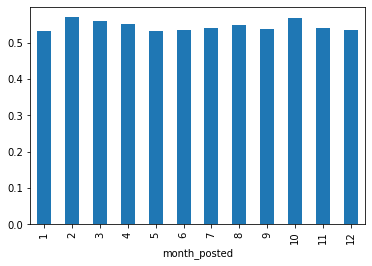

In [95]:
month_posted = new_df['status_dummy'].groupby(new_df['month_posted']).mean()
month_posted.plot.bar()

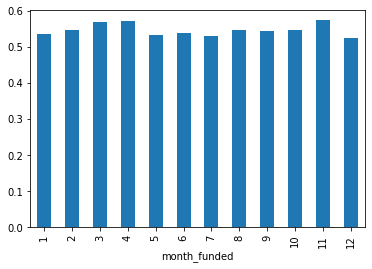

In [96]:
month_funded = new_df['status_dummy'].groupby(new_df['month_funded']).mean()
month_funded.plot.bar()

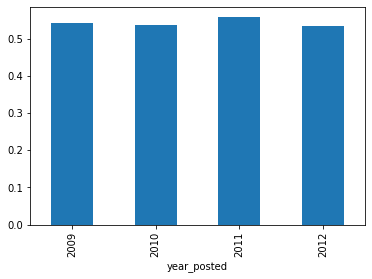

In [97]:
year_posted = new_df['status_dummy'].groupby(new_df['year_posted']).mean()
year_posted.plot.bar()

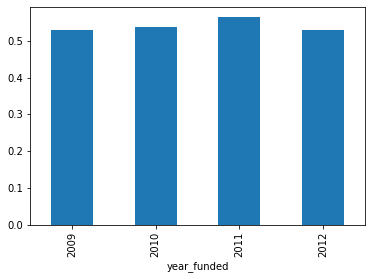

In [98]:
year_funded = new_df['status_dummy'].groupby(new_df['year_funded']).mean()
year_funded.plot.bar()

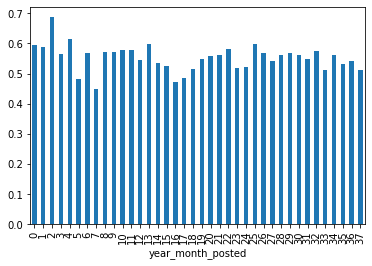

In [99]:
year_month_posted = new_df['status_dummy'].groupby(new_df['year_month_posted']).mean()
year_month_posted.plot.bar()

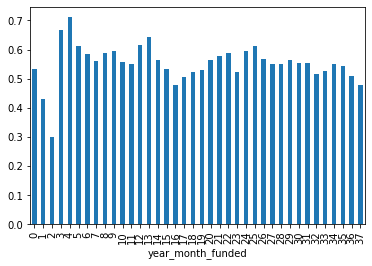

In [100]:
year_month_funded = new_df['status_dummy'].groupby(new_df['year_month_funded']).mean()
year_month_funded.plot.bar()

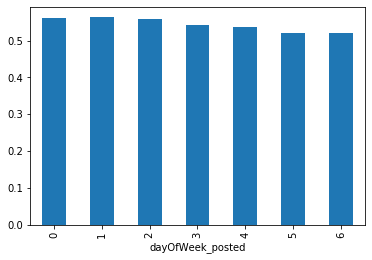

In [101]:
weekDayPosted = new_df['status_dummy'].groupby(new_df['dayOfWeek_posted']).mean()
weekDayPosted.plot.bar()

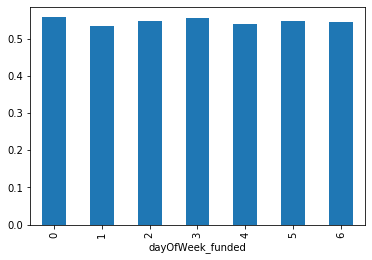

In [102]:
weekDayFunded = new_df['status_dummy'].groupby(new_df['dayOfWeek_funded']).mean()
weekDayFunded.plot.bar()

## Look at the distribution of the independent variables 

In [184]:
X = new_df[['year_funded_dummy', 'year_posted_dummy', 'month_funded_dummy', 'month_posted_dummy', 
            'year_month_funded', 'year_month_posted', 'category_dummy', 'subcategory_dummy','country_dummy', 'duration', 
           'day_funded', 'day_posted','dayOfWeek_posted', 'dayOfWeek_funded', 'goal']]
y = new_df['status_dummy']

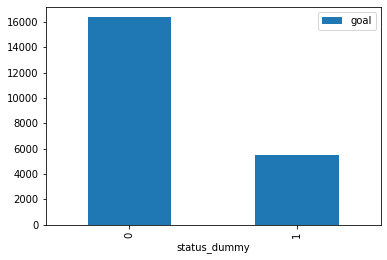

In [185]:
#On average, successful projects set lower goals
new_df[['status_dummy','goal']].groupby('status_dummy').mean().plot.bar()

In [186]:
new_df['status_dummy'].value_counts()

1    22902
0    18939
Name: status_dummy, dtype: int64

(array([18939., 22902.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

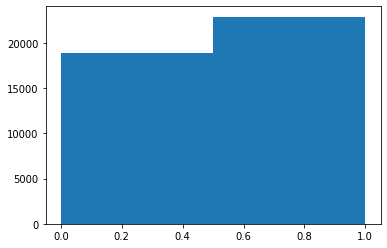

In [187]:
plt.hist(new_df['status_dummy'].T, bins=len(new_df['status_dummy'].value_counts()))

(array([  700.,  7231., 20124., 13786.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

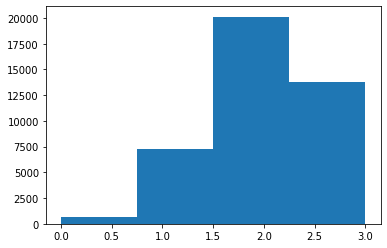

In [188]:
plt.hist(new_df['year_funded_dummy'].T, bins=len(new_df['year_funded_dummy'].value_counts()))

(array([ 1031.,  8309., 21063., 11438.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

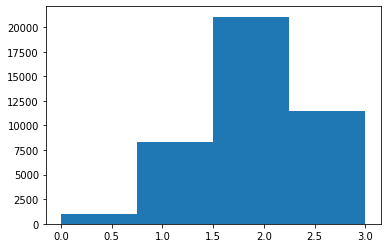

In [189]:
plt.hist(new_df['year_posted_dummy'].T, bins=len(new_df['year_posted_dummy'].value_counts()))

(array([3093., 3224., 4539., 5108., 5696., 2840., 2841., 3037., 2748.,
        2789., 2634., 3292.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <a list of 12 Patch objects>)

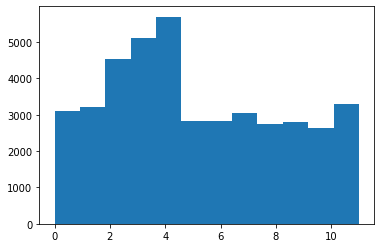

In [190]:
plt.hist(new_df['month_funded_dummy'].T, bins=len(new_df['month_funded_dummy'].value_counts()))

(array([3749., 4475., 5337., 4995., 3082., 2781., 2776., 2644., 2840.,
        2982., 3280., 2900.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <a list of 12 Patch objects>)

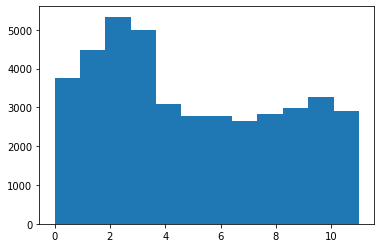

In [191]:
plt.hist(new_df['month_posted_dummy'].T, bins=len(new_df['month_posted_dummy'].value_counts()))

(array([ 163.,  223.,   10.,   24.,   52.,   49.,   65.,  114.,  168.,
         173.,  844.,  975.,  241.,  312.,  448.,  603.,  882.,  890.,
         847.,  848.,  957., 1017., 1627., 2094., 1400., 1649., 1889.,
        1823., 1907., 2098., 1836., 1827., 1968., 2034., 2898., 3147.,
        3349.,  390.]),
 array([ 0.        ,  0.97368421,  1.94736842,  2.92105263,  3.89473684,
         4.86842105,  5.84210526,  6.81578947,  7.78947368,  8.76315789,
         9.73684211, 10.71052632, 11.68421053, 12.65789474, 13.63157895,
        14.60526316, 15.57894737, 16.55263158, 17.52631579, 18.5       ,
        19.47368421, 20.44736842, 21.42105263, 22.39473684, 23.36842105,
        24.34210526, 25.31578947, 26.28947368, 27.26315789, 28.23684211,
        29.21052632, 30.18421053, 31.15789474, 32.13157895, 33.10526316,
        34.07894737, 35.05263158, 36.02631579, 37.        ]),
 <a list of 38 Patch objects>)

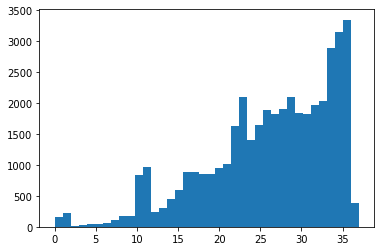

In [192]:
plt.hist(new_df['year_month_funded'].T, bins=len(new_df['year_month_funded'].value_counts()))

(array([ 182.,  163.,   16.,   55.,   52.,   58.,   88.,  270.,  147.,
         233.,  295., 1007.,  980.,  412.,  536.,  592.,  886.,  839.,
         741.,  832.,  956., 1241., 1450., 2091., 1757., 1688., 1837.,
        1845., 1843., 1879., 1815., 1738., 1879., 2275., 2730., 3237.,
        2606.,  590.]),
 array([ 0.        ,  0.97368421,  1.94736842,  2.92105263,  3.89473684,
         4.86842105,  5.84210526,  6.81578947,  7.78947368,  8.76315789,
         9.73684211, 10.71052632, 11.68421053, 12.65789474, 13.63157895,
        14.60526316, 15.57894737, 16.55263158, 17.52631579, 18.5       ,
        19.47368421, 20.44736842, 21.42105263, 22.39473684, 23.36842105,
        24.34210526, 25.31578947, 26.28947368, 27.26315789, 28.23684211,
        29.21052632, 30.18421053, 31.15789474, 32.13157895, 33.10526316,
        34.07894737, 35.05263158, 36.02631579, 37.        ]),
 <a list of 38 Patch objects>)

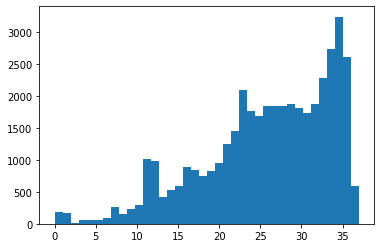

In [193]:
plt.hist(new_df['year_month_posted'].T, bins=len(new_df['year_month_posted'].value_counts()))

(array([ 3684.,   965.,   704.,  1561.,  1018., 12550.,  1291.,  1460.,
        10031.,  1380.,  4150.,   732.,  2315.]),
 array([ 0.        ,  0.92307692,  1.84615385,  2.76923077,  3.69230769,
         4.61538462,  5.53846154,  6.46153846,  7.38461538,  8.30769231,
         9.23076923, 10.15384615, 11.07692308, 12.        ]),
 <a list of 13 Patch objects>)

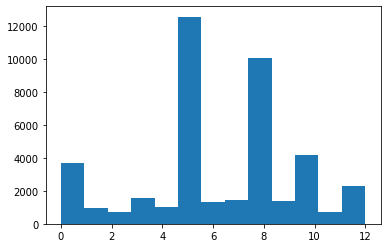

In [194]:
plt.hist(new_df['category_dummy'].T, bins=len(new_df['category_dummy'].value_counts()))

(array([ 376., 1008.,  301.,  471.,  542.,  430.,  965.,  167.,  987.,
         228.,  704.,  260.,  134., 3674.,  269., 1018.,  943., 2333.,
        1291.,  239.,  163.,  420.,  187., 1812.,  414.,  404.,  407.,
        3000., 1408.,  881.,  170.,  234.,  483.,  460.,  263., 1380.,
         200.,  690.,  910.,  509.,  616., 1627.,  329., 3735.,  328.,
        2315.,  750., 1024.,  382.]),
 array([ 0.        ,  0.97959184,  1.95918367,  2.93877551,  3.91836735,
         4.89795918,  5.87755102,  6.85714286,  7.83673469,  8.81632653,
         9.79591837, 10.7755102 , 11.75510204, 12.73469388, 13.71428571,
        14.69387755, 15.67346939, 16.65306122, 17.63265306, 18.6122449 ,
        19.59183673, 20.57142857, 21.55102041, 22.53061224, 23.51020408,
        24.48979592, 25.46938776, 26.44897959, 27.42857143, 28.40816327,
        29.3877551 , 30.36734694, 31.34693878, 32.32653061, 33.30612245,
        34.28571429, 35.26530612, 36.24489796, 37.2244898 , 38.20408163,
        39.18367347, 40

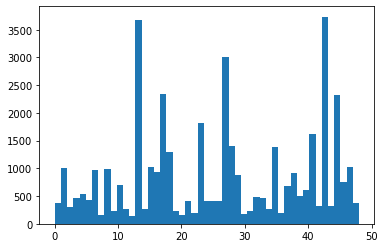

In [195]:
plt.hist(new_df['subcategory_dummy'].T, bins=len(new_df['subcategory_dummy'].value_counts()))

(array([2978., 1916., 1321., 1301., 1317., 1254., 1252., 1207., 1157.,
        1333., 1321., 1292., 1180., 1265., 1601., 1648., 1232., 1344.,
        1273., 1341., 1386., 1192., 1207., 1238., 1316., 1278., 1168.,
        1110., 1076., 1223., 1114.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <a list of 31 Patch objects>)

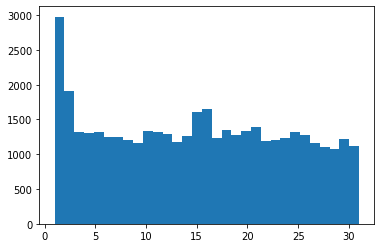

In [196]:
plt.hist(new_df['day_funded'].T, bins=len(new_df['day_funded'].value_counts()))

(array([1727., 1646., 1515., 1362., 1338., 1372., 1409., 1338., 1514.,
        1368., 1317., 1322., 1449., 1361., 1442., 1480., 1371., 1218.,
        1447., 1395., 1396., 1377., 1366., 1249., 1198., 1239., 1321.,
        1293., 1142., 1158.,  711.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <a list of 31 Patch objects>)

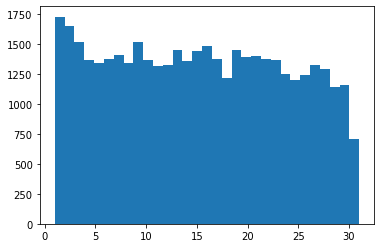

In [197]:
plt.hist(new_df['day_posted'].T, bins=len(new_df['day_posted'].value_counts()))

(array([6521., 7395., 7183., 7148., 6415., 4084., 3095.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

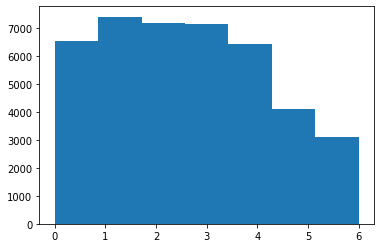

In [198]:
plt.hist(new_df['dayOfWeek_posted'].T, bins=len(new_df['dayOfWeek_posted'].value_counts()))

(array([6111., 5151., 5376., 5950., 6312., 6698., 6243.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

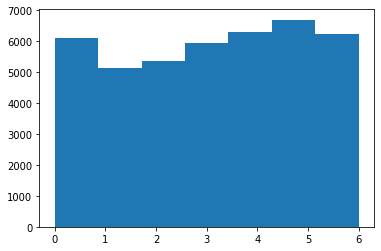

In [199]:
plt.hist(new_df['dayOfWeek_funded'].T, bins=len(new_df['dayOfWeek_funded'].value_counts()))

# Grid search

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [201]:
t0 = time.time()
eval_set = [(X_test, y_test)]
param_grid = {
                'learning_rate': [0.1, 0.2, 0.3],
              'max_depth':[3, 4, 5, 6, 7, 8, 9, 10], 
                }

xgb = XGBClassifier(cv=5, param_grid=param_grid,use_label_encoder=False, verbosity=0, early_stopping_rounds=50)

xgb_search = GridSearchCV(xgb, param_grid=param_grid, return_train_score=True, verbose=0, scoring='f1', cv=5)

xgb_search.fit(X_train, y_train, eval_set=eval_set, verbose=0)
print(time.time() - t0)

279.75510573387146


In [202]:
df= pd.DataFrame(xgb_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,1.257811,0.125158,0.016800,0.001469,0.1,4,"{'learning_rate': 0.1, 'max_depth': 4}",0.713208,0.716009,0.708024,...,0.712654,0.002728,1,0.728207,0.727519,0.730497,0.728820,0.726938,0.728396,0.001226
0,0.925802,0.102325,0.015198,0.001167,0.1,3,"{'learning_rate': 0.1, 'max_depth': 3}",0.716298,0.713683,0.706873,...,0.712294,0.003173,2,0.721283,0.720216,0.724264,0.719968,0.720858,0.721318,0.001545
8,1.013850,0.049796,0.015601,0.001357,0.2,3,"{'learning_rate': 0.2, 'max_depth': 3}",0.715579,0.712817,0.708395,...,0.711972,0.002380,3,0.726580,0.725385,0.727119,0.725617,0.726320,0.726204,0.000634
2,1.525354,0.081447,0.018201,0.001169,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",0.713166,0.707828,0.710088,...,0.710078,0.001779,4,0.742018,0.738786,0.740297,0.741060,0.739545,0.740341,0.001130
16,1.008206,0.099120,0.016394,0.001352,0.3,3,"{'learning_rate': 0.3, 'max_depth': 3}",0.710265,0.713048,0.707667,...,0.709565,0.001942,5,0.732671,0.730750,0.730453,0.731363,0.730744,0.731196,0.000795


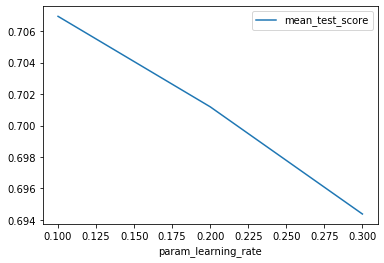

In [203]:
df[['param_learning_rate', 'mean_test_score']].groupby('param_learning_rate').mean().plot()

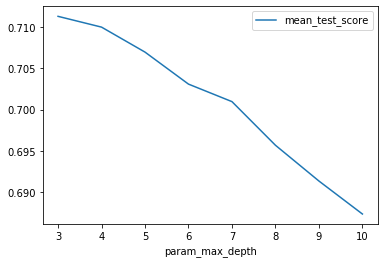

In [204]:
df[['param_max_depth', 'mean_test_score']].groupby('param_max_depth').mean().plot()

In [205]:
xgb_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=5,
              early_stopping_rounds=50, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic',
              param_grid={'learning_rate': [0.1, 0.2, 0.3],
                          'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [206]:
xgb_search.best_score_

0.7126537796285083

In [207]:
xgb_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4}

In [208]:
xgb_search.scorer_

make_scorer(f1_score, average=binary)

In [209]:
xgb_search.n_splits_

5

# Randomized Search 

In [211]:
t0 = time.time()
logistic = LogisticRegression()
distributions = dict(C=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                      penalty=['l2'],
                    solver=['newton-cg','lbfgs', 'sag'])
                    #l1_ratio=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

test = RandomizedSearchCV(logistic, distributions, cv=5, n_iter=100, scoring='f1', 
                          verbose=0, error_score = np.nan, random_state=0, return_train_score=True)
test.fit(X, y)
print(time.time() - t0)

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWar

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge


C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm 

C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  wa

C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklear

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge


C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packag

173.55074429512024


C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [212]:
df = pd.DataFrame(test.cv_results_)
df.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
18,1.664008,0.125759,0.007203,0.000743,newton-cg,l2,0.7,"{'solver': 'newton-cg', 'penalty': 'l2', 'C': ...",0.715035,0.705129,...,0.709059,0.003246,1,0.708768,0.709187,0.708975,0.709032,0.709563,0.709105,0.000265
24,2.030825,0.338322,0.006001,0.001096,newton-cg,l2,0.9,"{'solver': 'newton-cg', 'penalty': 'l2', 'C': ...",0.715101,0.705129,...,0.709049,0.003276,2,0.708785,0.709230,0.709021,0.709032,0.709546,0.709123,0.000255
15,1.574249,0.187983,0.005390,0.001347,newton-cg,l2,0.6,"{'solver': 'newton-cg', 'penalty': 'l2', 'C': ...",0.714970,0.705129,...,0.709046,0.003222,3,0.708739,0.709187,0.709005,0.709032,0.709546,0.709102,0.000265
21,1.717002,0.216380,0.006001,0.001087,newton-cg,l2,0.8,"{'solver': 'newton-cg', 'penalty': 'l2', 'C': ...",0.715035,0.705009,...,0.709035,0.003276,4,0.708785,0.709170,0.709021,0.709032,0.709546,0.709111,0.000251
9,1.940252,0.195651,0.007001,0.002282,newton-cg,l2,0.4,"{'solver': 'newton-cg', 'penalty': 'l2', 'C': ...",0.714904,0.705129,...,0.709033,0.003198,5,0.708690,0.709187,0.708926,0.709032,0.709546,0.709076,0.000285


## Conduct Logistic Regression

In [213]:
new_df.columns

Index(['project id', 'name', 'url', 'category', 'subcategory', 'location',
       'status', 'goal', 'pledged', 'funded percentage', 'backers',
       'funded date', 'levels', 'reward levels', 'updates', 'comments',
       'duration', 'duration_td', 'Posting_Date', 'year_funded',
       'month_funded', 'day_funded', 'time_funded', 'dayOfWeek_funded',
       'year_posted', 'month_posted', 'day_posted', 'time_posted',
       'dayOfWeek_posted', 'city', 'state', 'country', 'category_dummy',
       'subcategory_dummy', 'status_dummy', 'year_posted_dummy',
       'year_funded_dummy', 'month_posted_dummy', 'month_funded_dummy',
       'country_dummy', 'year_month_posted', 'year_month_funded'],
      dtype='object')

In [214]:
def thread_training(X_train, y_train, X_test, y_test, solver, C):
    threads = min(100, len(solver)*len(C)*2)
    output = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        for s in solver:
            for c in C:
                if s in ['newton-cg','lbfgs', 'sag']:
                    output[executor.submit(run_regression, X_train, y_train, solver=s, penalty='l2', C=c)] = (s, 'l2', c)
                elif s =='saga':
                    for p in ['l1', 'l2', 'elasticnet']:
                        if p == 'elasticnet':
                            for l1 in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
                                output[executor.submit(run_regression, X_train, y_train, solver=s, penalty=p, C=c, l1_ratio=l1)] =(s,p,c,l1)
                        else:
                            output[executor.submit(run_regression, X_train, y_train, solver=s, penalty=p, C=c)] = (s, p, c)
                else:
                    for p in ['l1', 'l2']:
                        output[executor.submit(run_regression, X_train, y_train, solver=s, penalty=p, C=c)] = (s, p, c)
    return output

def thread_save(results, X_train, y_train, X_test, y_test):
    threads = min(100, len(results))
    output = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        for each in results:
            output[each] = executor.submit(save_results, each, X_train, y_train, X_test, y_test)
    return output

def run_regression(X_train, y_train, solver, penalty, C, l1_ratio=None):

    reg = LogisticRegression(C=C, penalty=penalty, 
                             random_state=0, solver=solver, 
                             max_iter=100,l1_ratio=l1_ratio).fit(X_train, y_train)
    return reg

def save_results(results, X_train, y_train, X_test, y_test):
        y_pred = results.result().predict(X_test)
        tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
        return {'penalty':results.result().penalty, 
                           'solver':results.result().solver, 
                           'train_score':results.result().score(X_train, y_train), 
                           'test_score': results.result().score(X_test, y_test),
                           'f1_score': f1_score(y_test, y_pred),
                           'true_positive_rate':tp/(tp + fp),
                           'true_negative_rate':tn/(tn+fn),
                           'l1_ratio':results.result().l1_ratio,
                           'C': results.result().C
                          }

In [215]:
t0 = time.time()
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
                
results = thread_training(X_train, y_train, X_test, y_test, solver, C)
summary_stats = thread_save(results, X_train, y_train, X_test, y_test)
print(time.time() - t0)

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rayde\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_laun

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 du

73.26833629608154


In [247]:
df = pd.DataFrame([each.result() for each in summary_stats.values()], dtype='float64').sort_values(by='test_score', ascending=False)
len(df)

160

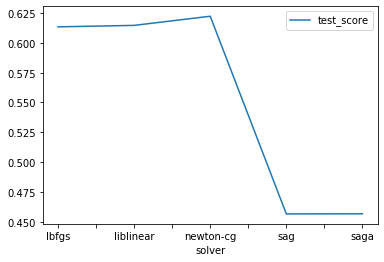

In [217]:
df['test_score'] = df['test_score'].astype('float64')
df[['test_score','solver']].groupby('solver').mean().plot()

In [218]:
df.columns

Index(['penalty', 'solver', 'train_score', 'test_score', 'f1_score',
       'true_positive_rate', 'true_negative_rate', 'l1_ratio', 'C'],
      dtype='object')

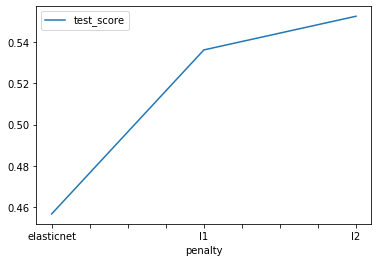

In [219]:
df[['test_score','penalty']].groupby('penalty').mean().plot()

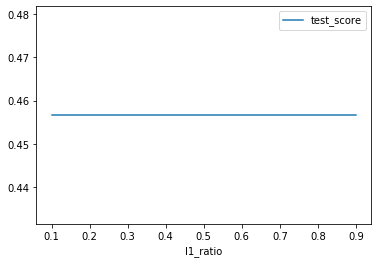

In [220]:
df[['test_score','l1_ratio']].groupby('l1_ratio').mean().plot()

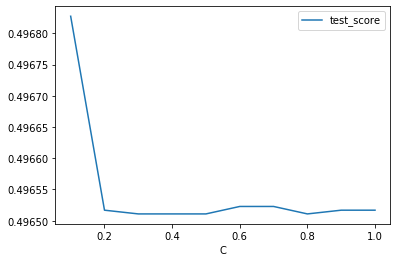

In [221]:
df[['test_score','C']].groupby('C').mean().plot()

## Gaussian Naive Bayes
### Gaussian Naive Bayes supports continuous valued features and models each as conforming to a Gaussian (normal) distribution.

In [222]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_train, y_train))
print(gnb.score(X_test, y_test))
y_pred = gnb.predict(X_test)
tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(f'CONFUSION MATRIX', '\ntrue positive rate: ', tp/(tp + fp),'\ntrue negative rate: ', tn/(tn+fn), 
        '\nPercent predicted correctly: ', (tp+tn)/(tp+fp+tn+fn), '\nf1_score: ', f1_score(y_test, y_pred))

0.5738368387507967
0.5723162221584934
CONFUSION MATRIX 
true positive rate:  0.5601750547045952 
true negative rate:  0.8722358722358723 
Percent predicted correctly:  0.5723162221584934 
f1_score:  0.7157199135849536


In [223]:
gaussiannb = {}
num = 1

for var_smoothing in [.1, 1e-2, 1e-3, 1e-4, 0]:
    gnb = GaussianNB(var_smoothing=var_smoothing)
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
    gaussiannb[num] = {'true_positive_rate':tp/(tp + fp), 
                       'true_negative_rate': tn/(tn+fn), 
                       'train_score':gnb.score(X_train, y_train),
                       'test_score':gnb.score(X_test, y_test),
                       'var_smoothing': var_smoothing, 
                      'f1_score':f1_score(y_test, y_pred)}
    num+=1

In [224]:
df = pd.DataFrame(gaussiannb).T.sort_values(by='test_score', ascending=False)
df

,true_positive_rate,true_negative_rate,train_score,test_score,var_smoothing,f1_score
5,0.560386,0.875306,0.574283,0.572699,0.0000,0.715938
4,0.559495,0.870229,0.572913,0.571169,0.0001,0.715211
3,0.558940,0.866841,0.572498,0.570213,0.0010,0.714757
2,0.553364,0.922727,0.562811,0.561132,0.0100,0.711711
1,0.546417,0.939394,0.554557,0.548896,0.1000,0.706512


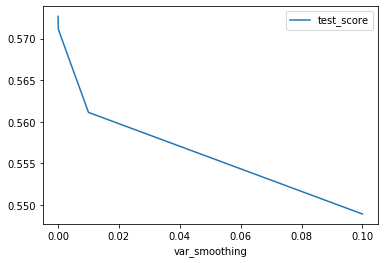

In [225]:
df[['test_score','var_smoothing']].groupby('var_smoothing').mean().plot()

## Random Forest

In [226]:
random_forest = {}
num = 1
for criterion in ['gini', 'entropy']:
    for max_features in ["auto", "sqrt", "log2"]:
        for bootstrap in [True, False]:
            if bootstrap==True:
                for oob_score in [True, False]:
                    random = RandomForestClassifier(criterion=criterion, max_features = max_features, bootstrap=bootstrap, 
                                                    oob_score=oob_score, n_jobs=-1, random_state=0, n_estimators=100)
                    random.fit(X_train, y_train)
                    y_pred = gnb.predict(X_test)
                    tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
                    random_forest[num] = {'criterion': criterion, 'max_features':max_features, 'bootstrap':bootstrap, 
                                       'oob_score':oob_score, 'train_score':random.score(X_train, y_train), 
                                       'test_score':random.score(X_test, y_test), 'true_positive_rate':tp/(tp + fp), 
                                      'true_negative_rate':tn/(tn+fn), 'f1_score': f1_score(y_test, y_pred)}
                    num+=1
            else:
                random = RandomForestClassifier(criterion=criterion, max_features = max_features, bootstrap=bootstrap, 
                                                n_jobs=-1, random_state=0, n_estimators=100)
                random.fit(X_train, y_train)

                y_pred = gnb.predict(X_test)
                tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
                random_forest[num] = {'criterion': criterion, 'max_features':max_features, 'bootstrap':bootstrap, 
                                       'oob_score':None, 'train_score':random.score(X_train, y_train), 
                                       'test_score':random.score(X_test, y_test), 'true_positive_rate':tp/(tp + fp), 
                                      'true_negative_rate':tn/(tn+fn), 'f1_score': f1_score(y_test, y_pred)}
                num+=1


In [227]:
df = pd.DataFrame(random_forest).T.sort_values(by='test_score', ascending=False)
df

,criterion,max_features,bootstrap,oob_score,train_score,test_score,true_positive_rate,true_negative_rate,f1_score
1,gini,auto,True,True,0.997068,0.633687,0.560386,0.875306,0.715938
4,gini,sqrt,True,True,0.997068,0.633687,0.560386,0.875306,0.715938
5,gini,sqrt,True,False,0.997068,0.633687,0.560386,0.875306,0.715938
7,gini,log2,True,True,0.997068,0.633687,0.560386,0.875306,0.715938
8,gini,log2,True,False,0.997068,0.633687,0.560386,0.875306,0.715938
2,gini,auto,True,False,0.997068,0.633687,0.560386,0.875306,0.715938
13,entropy,sqrt,True,True,0.997068,0.632158,0.560386,0.875306,0.715938
17,entropy,log2,True,False,0.997068,0.632158,0.560386,0.875306,0.715938
16,entropy,log2,True,True,0.997068,0.632158,0.560386,0.875306,0.715938
14,entropy,sqrt,True,False,0.997068,0.632158,0.560386,0.875306,0.715938


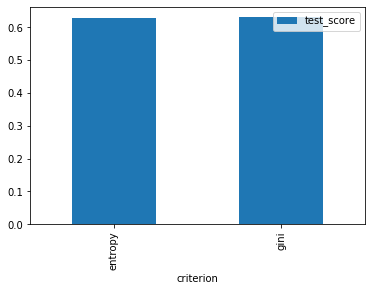

In [228]:
df['test_score'] = df['test_score'].astype('float64')
df[['criterion', 'test_score']].groupby('criterion').mean().plot.bar()

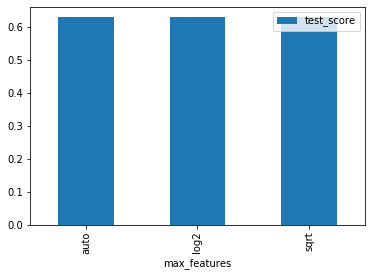

In [229]:
df[['max_features', 'test_score']].groupby('max_features').mean().plot.bar()

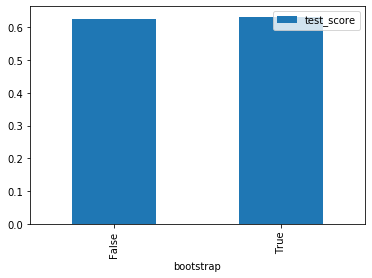

In [230]:
df[['bootstrap', 'test_score']].groupby('bootstrap').mean().plot.bar()

## Extreme Gradient Booster

In [244]:
learning_rate = [0.1, 0.2, 0.3]
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
eval_set = [(X_test, y_test)]
EGB = {}
num = 1
for lr in learning_rate:
    for md in max_depth:
        xg = XGBClassifier(learning_rate=lr, max_depth=md, use_label_encoder=False)
        xg.fit(X_train, y_train, eval_metric='logloss', eval_set=eval_set, 
                    early_stopping_rounds=50, verbose=False)
        EGB[num] = {'learning_rate': lr, 'max_depth': md, 
                           'train_score': xg.score(X_train, y_train), 
                           'test_score':xg.score(X_test, y_test)}
        num+=1

In [245]:
df = pd.DataFrame(EGB).T.sort_values(by='test_score', ascending=False)
df.head()

,learning_rate,max_depth,train_score,test_score
4,0.1,6.0,0.702804,0.662461
3,0.1,5.0,0.690918,0.659880
18,0.3,4.0,0.678808,0.659880
19,0.3,5.0,0.698630,0.659593
10,0.2,4.0,0.683461,0.658541


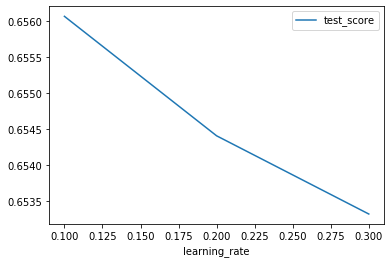

In [246]:
df[['learning_rate', 'test_score']].groupby('learning_rate').mean().plot()

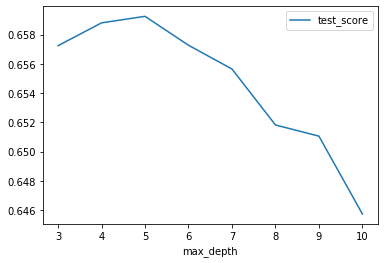

In [234]:
df[['max_depth', 'test_score']].groupby('max_depth').mean().plot()

In [235]:
xg.best_score
xg.feature_importances_

array([0.04857403, 0.0576419 , 0.05374594, 0.06184004, 0.0561284 ,
       0.06078327, 0.10895972, 0.06971295, 0.06700084, 0.07346443,
       0.05573682, 0.05646444, 0.05780649, 0.05219891, 0.11994188],
      dtype=float32)

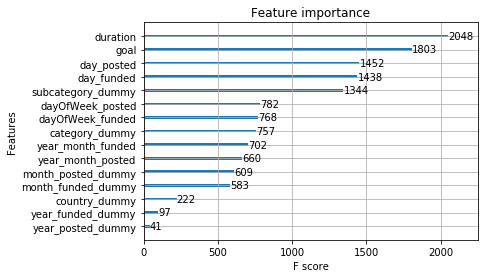

In [236]:
plot_importance(xg)

In [237]:
count=1
select = {}

for thresh in sorted(xg.feature_importances_):
    # select features using threshold
    selection = SelectFromModel(xg, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # train model
    selection_model = XGBClassifier(learning_rate=.1, max_depth=5, use_label_encoder=False)
    selection_model.fit(select_X_train, y_train, eval_metric='logloss', eval_set=[(select_X_test, y_test)], 
                        early_stopping_rounds=50, verbose=False)
    # eval model
    y_pred = selection_model.predict(select_X_test)
    select[count] = {'threshold': thresh,
                         'num_features': select_X_train.shape[1], 
                         'f1_score': f1_score(y_pred, y_test)
                    }
    count+=1

In [238]:
pd.DataFrame(select).T.sort_values(by='f1_score', ascending=False)

,threshold,num_features,f1_score
5,0.056128,11.0,0.707434
7,0.057642,9.0,0.707385
8,0.057806,8.0,0.707385
9,0.060783,7.0,0.707265
6,0.056464,10.0,0.706425
3,0.053746,13.0,0.706386
1,0.048574,15.0,0.706096
2,0.052199,14.0,0.706096
10,0.061840,6.0,0.705756
4,0.055737,12.0,0.705378


In [242]:
dtrain = xg.DMatrix(X_train,y_train)
dtest = xg.DMatrix(X_test,y_test)

D_matrix = {}

param = {'learning_rate':.1,
         'max_depth':5, 
         'objective': 'binary:logistic',
         'eval_metric': 'logloss'}

num_round = 300
cv = xgboost.cv(param, dtrain, num_round)

In [243]:
cv.sort_values(by='test-logloss-mean')

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
84,0.577241,0.001088,0.617501,0.002476
85,0.576736,0.001073,0.617535,0.002404
83,0.577731,0.001107,0.617568,0.002454
80,0.578918,0.001098,0.617589,0.002288
97,0.572426,0.001038,0.617593,0.002306
...,...,...,...,...
4,0.653385,0.000852,0.656577,0.000719
3,0.658764,0.000566,0.661398,0.000692
2,0.665078,0.000370,0.667130,0.000593
1,0.672756,0.000380,0.674177,0.000457
